# imports

In [235]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

#device = 0
#torch.cuda.set_device(device)

%reload_ext autoreload
%autoreload 2
#%matplotlib notebook
%matplotlib inline

from typing import List, Callable, Tuple, Dict

import sys

#https://github.com/FAU-DLM/wsi_processing_pipeline
sys.path.append("../")
sys.path.append("../wsi_processing_pipeline/")
sys.path.append("../wsi_processing_pipeline/tile_extraction")
sys.path.append("../wsi_processing_pipeline/shared")
import wsi_processing_pipeline
import tile_extraction
import preprocessing
import shared
from wsi_processing_pipeline.tile_extraction import tiles, util, slide, filter
from wsi_processing_pipeline import shared

from wsi_processing_pipeline.preprocessing import *
import wsi_processing_pipeline.preprocessing.files_getter
import wsi_processing_pipeline.preprocessing.name_getter
from wsi_processing_pipeline.preprocessing.name_getter import NameGetter
from wsi_processing_pipeline.preprocessing.tile_image_block import TileImage, label_tl_image, tile_image, TileTransform
from wsi_processing_pipeline.preprocessing.tile_image_block import show_batch, TileImageBlock
from shared.patient_manager import PatientManager
import shared


sys.path.append('../models-pytorch/pretrained-models.pytorch')
import pretrainedmodels
from pretrainedmodels import *


import fastai
from fastai.vision.all import *


from typing import Dict
import pandas as pd
import numpy as np
import os
import torch
import torchvision
from torchvision.models import *
from torchsummary import summary
from functools import partial, update_wrapper
from tqdm import tqdm_notebook as tqdm
import matplotlib.image as mpimg
import shutil
from PIL import Image
import sklearn
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold

import pathlib
from pathlib import Path
Path.ls = lambda x: [p for p in list(x.iterdir()) if '.ipynb_checkpoints' not in p.name]

#against DecompressionBombWarning
Image.MAX_IMAGE_PIXELS = 10000000000   

PATH = Path('/home/Deep_Learner/private/datasets/Hypophysenadenome/')

WSIS_CORTICOTROP = PATH/'corticotrop'
WSIS_GONADOTROP = PATH/'gonadotrop'

ROIS_CORTICOTROP = PATH/'corticotrop_ROIs'
ROIS_GONADOTROP = PATH/'gonadotrop_ROIs'

TILES_CORTICOTROP_1 = PATH/'tiles_corticotrop_1_scoring_function_1_thresh_0.55'
TILES_CORTICOTROP_2 = PATH/'tiles_corticotrop_2_scoring_function_1_thresh_0.55'
TILES_CORTICOTROP_3 = PATH/'tiles_corticotrop_3_scoring_function_1_thresh_0.4'

TILES_GONADOTROP_1 = PATH/'tiles_gonadotrop_1_scoring_function_1_thresh_0.55'
TILES_GONADOTROP_2 = PATH/'tiles_gonadotrop_2_scoring_function_1_thresh_0.55'
TILES_GONADOTROP_3 = PATH/'tiles_gonadotrop_3_scoring_function_1_thresh_0.4'

#TEST = PATH/TEST_NAME
#TEST = PATH_LOCAL/TEST_NAME
TEST_EXPERIMENTING = PATH/'tiles_test_100_for_testing'
LABELS_CORTICOTROP_NAME = 'KortikotropHA_gelabled.xlsx'
LABELS_CORTICOTROP = PATH/LABELS_CORTICOTROP_NAME
LABELS_GONADOTROP_NAME = 'GonadotropeHA_gelabled.xlsx'
LABELS_GONADOTROP = PATH/LABELS_GONADOTROP_NAME
MODEL_PATH_NAME = 'models'
MODEL_PATH = PATH/MODEL_PATH_NAME

ROIS_EXPERIMENTING = PATH/'rois_experimenting'
TILES_EXPERIMENTING = PATH/'tiles_experimenting'

torch.backends.cudnn.benchmark=True


seed = 19
np.random.seed(seed)

num2lbs = {
    0:"corticotrop", 
    1:"silent",  
    2:"LH", 
    3:"FSH"
}

lbs2num = {l:n for n,l in num2lbs.items()}

# data preprocessing 

## id and label funcs

In [191]:
def get_case_id_from_path(path):
    """
    Arguments:
        path: tile path
    """
    path = Path(path)
    split = path.stem.split('-')
    return f'{split[0]}-{split[1]}'

def get_slide_name_from_path(path):
    """
    Arguments:
        path: tile path
    """
    path = Path(path)
    split = path.stem.split('-')
    try:
        return f'{split[0]}-{split[1]}-{split[2]}-{split[3]}'
    except IndexError:
        return f'{split[0]}-{split[1]}-{split[2]}'
    
df_c = pd.read_excel(LABELS_CORTICOTROP)
def label_func(path, roi = None):
    """
    Arguments:
        path: tile path
    """
    path = Path(path)
    s = path.stem  
    if('LH+FSH' in s):
        return [lbs2num['LH'],lbs2num['FSH']]
    elif 'LH' in s:       
        return [lbs2num['LH']]
    elif 'FSH' in s:        
        return [lbs2num['FSH']]
    elif 'ACTH' in s:
        result = [lbs2num['corticotrop']]
        id = get_case_id_from_path(path)
        l = df_c.loc[df_c.id == id].label
        try:
            if str(3) in str(l.values[0]):
                result.append(lbs2num['silent'])
        except:
            print(l.values)
            print(s)
            print(get_slide_name_from_path(path))
            raise
        return result
    
    
def label_func(path, roi = None):
    """
    Arguments:
        path: tile path
    """
    path = Path(path)
    s = path.stem  
    if('LH+FSH' in s):
        return ['LH','FSH']
    elif 'LH' in s:       
        return ['LH']
    elif 'FSH' in s:        
        return ['FSH']
    elif 'ACTH' in s:
        result = ['corticotrop']
        id = get_case_id_from_path(path)
        l = df_c.loc[df_c.id == id].label
        try:
            if str(3) in str(l.values[0]):
                result.append('silent')
        except:
            print(l.values)
            print(s)
            print(get_slide_name_from_path(path))
            raise
        return result

## Extract tiles from rois on the fly 

### roi paths

In [3]:
roi_paths=wsi_processing_pipeline.preprocessing.files_getter.FilesGetter().get_dirs_and_files(path=PATH, 
                                                                        get_files=True, 
                                                                        suffix='.png', 
                                                                        recursive=True, 
                                                                        folder_name=['gonadotrop_ROIs', 'corticotrop_ROIs'])

49it [00:12,  3.88it/s]


In [4]:
roi_paths = roi_paths[:5]

In [5]:
roi_paths.items[:5]

[Path('/home/Deep_Learner/private/datasets/Hypophysenadenome/gonadotrop_ROIs/393-13-Z-HE-ROI_18-LH+FSH.png'),
 Path('/home/Deep_Learner/private/datasets/Hypophysenadenome/gonadotrop_ROIs/1536-15-Z-HE-ROI_32-LH.png'),
 Path('/home/Deep_Learner/private/datasets/Hypophysenadenome/gonadotrop_ROIs/1048-12-III-HE-ROI_16-LH+FSH.png'),
 Path('/home/Deep_Learner/private/datasets/Hypophysenadenome/gonadotrop_ROIs/931-13-Z-HE-ROI_16-FSH.png'),
 Path('/home/Deep_Learner/private/datasets/Hypophysenadenome/gonadotrop_ROIs/105-15-Z-HE-ROI_27-LH+FSH.png')]

In [6]:
len(roi_paths.items)

5

In [7]:
len(ROIS_CORTICOTROP.ls() + ROIS_GONADOTROP.ls())

13169

### tile extraction

In [9]:
tile_size = 1024

In [10]:
tilesummaries = tiles.WsiOrROIToTilesMultithreaded(wsi_paths=roi_paths.items, 
                                                   tiles_folder_path=None, 
                                                   tile_height=tile_size, 
                                                   tile_width=tile_size, 
                                                   minimal_acceptable_tile_height=0.7, 
                                                   minimal_acceptable_tile_width=0.7, 
                                                   tile_score_thresh=0.3,
                                                   tile_scoring_function=tiles.scoring_function_1, 
                                                   level=0,
                                                   save_tiles=False, 
                                                   return_as_tilesummary_object=True, 
                                                   wsi_path_to_rois=None, 
                                                   verbose=False)

100%|██████████| 5/5 [00:44<00:00, 12.33s/it]

In [ ]:
for ts in tilesummaries:
    ts.show_wsi_with_marked_tiles()

### PatientManager

In [11]:
patient_manager = PatientManager()

In [12]:
patient_manager.create_from_tilesummaries(tilesummaries=tilesummaries, 
                                          patient_id_getter=get_case_id_from_path, #one case per patient
                                         case_id_getter= get_case_id_from_path, 
                                         slide_id_getter= get_slide_name_from_path, 
                                         labels_getter=label_func)

In [13]:
len(patient_manager.get_all_tiles())

81

In [14]:
n_splits=5
current_iteration=0
patient_manager.split_KFold_cross_validation(n_splits=n_splits, 
                                             current_iteration=current_iteration, 
                                             random_state = seed, 
                                             shuffle = True)

### data block api

In [15]:
final_size = 512
bs = 2

In [16]:
batch_tfms=[fastai2.data.transforms.Normalize.from_stats(*fastai2.vision.all.imagenet_stats)] \
.append(fastai2.vision.augment.aug_transforms(size=final_size,flip_vert=True))

In [17]:
data = fastai2.data.block.DataBlock(
        blocks=(TileImageBlock, fastai2.data.block.MultiCategoryBlock),
        get_x=lambda x: x, 
        get_y=lambda x: x.labels,
        splitter=fastai2.data.transforms.FuncSplitter(lambda x: x.get_dataset_type() == shared.enums.DatasetType.validation),
        item_tfms = fastai2.vision.augment.Resize(tile_size),
        batch_tfms=[])

dls = data.dataloaders(patient_manager.get_all_tiles(), bs=bs)

## Preextracted tiles

### tile paths

In [192]:
tile_paths=wsi_processing_pipeline.preprocessing.files_getter.FilesGetter().get_dirs_and_files(path=PATH, 
                                            get_files=True, 
                                            suffix='.png', 
                                            recursive=True, 
                                            folder_name=['tiles_corticotrop_1_scoring_function_1_thresh_0.55', 
                                                         'tiles_corticotrop_2_scoring_function_1_thresh_0.55', 
                                                         'tiles_corticotrop_3_scoring_function_1_thresh_0.4', 
                                                         'tiles_gonadotrop_1_scoring_function_1_thresh_0.55', 
                                                         'tiles_gonadotrop_2_scoring_function_1_thresh_0.55', 
                                                         'tiles_gonadotrop_3_scoring_function_1_thresh_0.4'])

49it [00:14,  3.39it/s]


In [81]:
len(tile_paths)

270410

In [193]:
random.seed(seed)
tile_paths = random.sample(tile_paths, 1000)

In [83]:
tile_paths[73]

Path('/home/Deep_Learner/private/datasets/Hypophysenadenome/tiles_corticotrop_1_scoring_function_1_thresh_0.55/114-18-III-HE-ROI_121-ACTH-tile-r3-c7-x6144-y2048-w1024-h1024.png')

In [84]:
tile_paths[73]

Path('/home/Deep_Learner/private/datasets/Hypophysenadenome/tiles_corticotrop_1_scoring_function_1_thresh_0.55/114-18-III-HE-ROI_121-ACTH-tile-r3-c7-x6144-y2048-w1024-h1024.png')

In [194]:
random_path = random.choice(tile_paths)
print(random_path)
print(f'case_id: {get_case_id_from_path(random_path)}')
print(f'slide_id: {get_slide_name_from_path(random_path)}')
print(f'labels: {label_func(random_path)}')

/home/Deep_Learner/private/datasets/Hypophysenadenome/tiles_gonadotrop_1_scoring_function_1_thresh_0.55/1680-15-III-HE-ROI_6-LH-tile-r2-c2-x1024-y1024-w1024-h1024.png
case_id: 1680-15
slide_id: 1680-15-III-HE
labels: ['LH']


### PatientManager

In [195]:
patient_manager = PatientManager()

In [196]:
patient_manager.create_from_preextracted_tiles(tile_paths=tile_paths, 
                                               patient_id_getter=get_case_id_from_path, #one case per patient
                                              case_id_getter=get_case_id_from_path, 
                                              slide_id_getter=get_slide_name_from_path, 
                                              labels_getter=label_func)

In [197]:
n_splits=5
current_iteration=0
patient_manager.split_KFold_cross_validation(n_splits=n_splits, 
                                             current_iteration=current_iteration, 
                                             random_state = seed, 
                                             shuffle = True)

### data block api

In [198]:
final_size = 512
bs = 6

data = fastai.data.block.DataBlock(
        blocks=(ImageBlock, fastai.data.block.MultiCategoryBlock),
        get_x=lambda x: x.tile_path, 
        get_y=lambda x: x.labels,
        splitter=fastai.data.transforms.FuncSplitter(lambda x: x.get_dataset_type() == shared.enums.DatasetType.validation),
        item_tfms = fastai.vision.augment.Resize(final_size),
        batch_tfms=fastai.vision.augment.aug_transforms(flip_vert=True))

dls = data.dataloaders(patient_manager.get_all_tiles(), bs=bs)

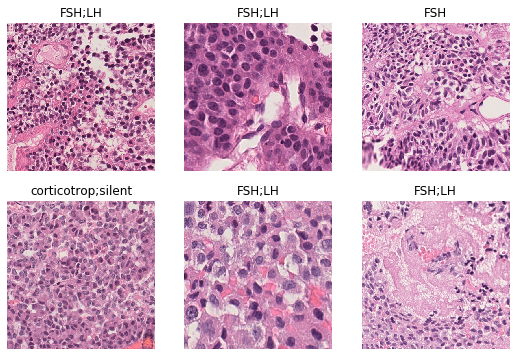

In [199]:
dls.show_batch()

# learner

## n

In [200]:
n = np.load('n_ent_f2.npy')
print(n)
#m = n+1
m=1
np.save('n_ent_f2.npy', m)
print(m)

1
1


## create

In [201]:
epochs_frozen = 5
epochs_unfrozen = 10

arch = torchvision.models.resnet.resnext101_32x8d

learner = cnn_learner(dls=dls, 
                     arch=arch, 
                     #metrics=[fastai.metrics.accuracy_multi, fastai.metrics.RocAucMulti],
                     pretrained=True)

# In fastai1 the bias of these two layers of the custom head is set to True. In fastai2 it is set to False.
# Since I want to load model weights, that were trained with fastai1, the two layers need to be replaced, so that the weights
# can be loaded correctly
learner.model[1][4] = torch.nn.Linear(in_features=4096, out_features=512, bias=True)
learner.model[1][8] = torch.nn.Linear(in_features=512, out_features=4, bias=True)

## name

In [202]:
nameBase = f'{n}-{arch.__name__}-size{final_size}-bs{bs}-epochs_head{epochs_frozen}'\
                f'epochs_complete{epochs_unfrozen}-seed_{seed}-n_splits_{n_splits}'\
                f'-tiles_1+2+3-cross_valid_iteration_{current_iteration}'
nameBase

'1-resnext101_32x8d-size512-bs6-epochs_head5epochs_complete10-seed_19-n_splits_5-tiles_1+2+3-cross_valid_iteration_0'

## train

In [ ]:
lr_min, lr_steep=learner.lr_find(start_lr=1e-10, end_lr=10, num_it=10)

In [28]:
## will skip this for now, since there are already trained models from the fastai 1 version of this pipeline

## load model weights

In [203]:
model_path = PATH/'models/13-resnext/13-resnext_cross-valid-iteration-0/models/bestmodel_lr2=1e-7--lr3=1e-6_2nd_run_9'

learner.load(model_path)

# prediction

In [433]:
from postprocessing.predictor import Predictor

In [434]:
predictor = Predictor(learner=learner, patient_manager=patient_manager)

In [435]:
predictor.predict_on_preextracted_tiles(dataset_type=shared.enums.DatasetType.validation,
                                       tile_size=512, batch_size=1)

247
247
247


In [432]:
patient_manager.get_tiles(dataset_type=shared.enums.DatasetType.validation)[0].predictions_raw

{'FSH': tensor(9.9955e-06),
 'LH': tensor(1.7253e-06),
 'corticotrop': tensor(0.9543),
 'silent': tensor(0.0496)}

In [ ]:
len(tiles_valid)

In [270]:
type(dl_pred.vocab)

fastai2.data.transforms.CategoryMap

In [257]:
type(preds)

tuple

In [258]:
Tuple[torch.Tensor, torch.Tensor]

(tensor([[9.9952e-06, 1.7252e-06, 9.5431e-01, 4.9583e-02],
         [1.3481e-07, 1.7413e-06, 9.7874e-01, 3.9362e-02],
         [7.3355e-13, 1.1644e-10, 9.8945e-01, 7.1461e-02],
         [7.0219e-19, 1.6329e-10, 1.0000e+00, 8.7172e-03],
         [1.7148e-11, 4.1671e-08, 9.7575e-01, 9.0057e-01],
         [2.0659e-07, 1.1035e-06, 9.9959e-01, 2.4307e-03],
         [2.8244e-22, 7.9792e-12, 1.0000e+00, 1.2497e-06],
         [6.6360e-20, 3.7762e-11, 1.0000e+00, 2.0053e-04],
         [7.2148e-33, 1.1645e-13, 1.0000e+00, 3.7682e-05],
         [2.0347e-29, 6.7878e-12, 1.0000e+00, 1.0058e-01],
         [3.0589e-06, 4.5987e-07, 9.4337e-01, 1.2721e-03],
         [8.5370e-18, 1.8262e-09, 1.0000e+00, 6.2520e-02],
         [7.8955e-36, 6.8765e-14, 1.0000e+00, 1.0596e-02],
         [3.4891e-37, 6.4563e-14, 1.0000e+00, 8.6504e-01],
         [5.6685e-32, 2.1677e-13, 1.0000e+00, 2.3964e-01],
         [1.0360e-20, 1.7039e-10, 1.0000e+00, 5.0185e-06],
         [2.8361e-09, 1.2859e-07, 9.9321e-01, 7.8952e-02

In [229]:
learner.dls.vocab

(#4) ['FSH','LH','corticotrop','silent']

In [227]:
tiles_valid[89].labels

['FSH']

In [226]:
dls.valid_ds[89]

(PILImage mode=RGB size=512x512, TensorMultiCategory([1., 0., 0., 0.]))

In [345]:
preds = learner.get_preds(ds_idx=1, with_input=False, with_decoded=False, reorder=False)

In [322]:
len(preds[1])

247

In [323]:
t = tiles_valid[0];t


/home/Deep_Learner/private/datasets/Hypophysenadenome/tiles_gonadotrop_1_scoring_function_1_thresh_0.55/270-15-III-HE-ROI_25-LH+FSH-tile-r5-c6-x5120-y4096-w1024-h1024.png

In [324]:
p_raw = preds[0][0];p_raw

tensor([9.9952e-06, 1.7252e-06, 9.5431e-01, 4.9583e-02])

In [325]:
dl_pred.vocab

(#4) ['FSH','LH','corticotrop','silent']

In [326]:
p_dict = {}
for c, pred in zip(dl_pred.vocab, p_raw):
    print(c)
    print(pred.item())
    p_dict[c] = pred.item()

FSH
9.995231266657356e-06
LH
1.7252451698368532e-06
corticotrop
0.954308807849884
silent
0.049583304673433304


In [327]:
p_dict

{'FSH': 9.995231266657356e-06,
 'LH': 1.7252451698368532e-06,
 'corticotrop': 0.954308807849884,
 'silent': 0.049583304673433304}

In [328]:
p = p_raw[0]

In [329]:
p.item()

9.995231266657356e-06

In [330]:
for i in range(0,len(tiles_valid)):
    print(preds[0][i])
    print(preds[1][i])
    print(tiles_valid[i])

tensor([9.9952e-06, 1.7252e-06, 9.5431e-01, 4.9583e-02])
tensor([1., 1., 0., 0.])
/home/Deep_Learner/private/datasets/Hypophysenadenome/tiles_gonadotrop_1_scoring_function_1_thresh_0.55/270-15-III-HE-ROI_25-LH+FSH-tile-r5-c6-x5120-y4096-w1024-h1024.png
tensor([1.3481e-07, 1.7413e-06, 9.7874e-01, 3.9362e-02])
tensor([1., 1., 0., 0.])
/home/Deep_Learner/private/datasets/Hypophysenadenome/tiles_gonadotrop_1_scoring_function_1_thresh_0.55/270-15-III-HE-ROI_11-LH+FSH-tile-r4-c4-x3072-y3072-w1024-h1024.png
tensor([7.3355e-13, 1.1644e-10, 9.8945e-01, 7.1461e-02])
tensor([0., 1., 0., 0.])
/home/Deep_Learner/private/datasets/Hypophysenadenome/tiles_gonadotrop_1_scoring_function_1_thresh_0.55/2194-14-III-HE-ROI_33-LH-tile-r4-c3-x2048-y3072-w957-h817.png
tensor([7.0219e-19, 1.6329e-10, 1.0000e+00, 8.7172e-03])
tensor([0., 1., 0., 0.])
/home/Deep_Learner/private/datasets/Hypophysenadenome/tiles_gonadotrop_1_scoring_function_1_thresh_0.55/2194-14-III-HE-ROI_20-LH-tile-r2-c2-x1024-y1024-w1024-h1024.

In [331]:
tiles_valid = [t for t in patient_manager.get_all_tiles() if t.get_dataset_type() == shared.enums.DatasetType.validation]

In [332]:
len(tiles_valid)

247

In [333]:
len(learner.dls.valid_ds)

247

In [346]:
preds = learner.get_preds(ds_idx=1, with_input=True, with_decoded=False, reorder=False)

In [347]:
data_pred = fastai.data.block.DataBlock(
            blocks=(ImageBlock, fastai.data.block.MultiCategoryBlock),
            get_x=lambda x: x.tile_path, 
            get_y=lambda x: x.labels,
            # all tiles that shall be predicted will be in the train dataset => split func has to return false for them
            splitter=fastai.data.transforms.FuncSplitter(lambda x: not (x.get_dataset_type() == shared.enums.DatasetType.validation)),
            item_tfms = fastai.vision.augment.Resize(512),
            batch_tfms=[])
dl_pred = data_pred.dataloaders(tiles_valid, bs=4, verbose=True)

Setting up after_item: Pipeline: Resize -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor


In [348]:
dl_pred.n

247

156


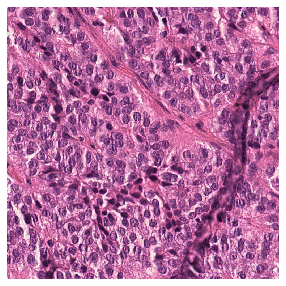

In [355]:
index = random.randint(0, len(tiles_valid)-1)
#index = 199
print(index)
#dls.valid_ds[index][0].show()

dl_pred.train_ds[index][0].show()

import PIL

#PIL.Image.open(tiles_valid[index].tile_path)

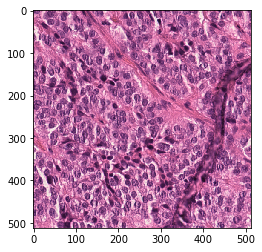

In [356]:
p = preds[0][index]

from torchvision.transforms import ToPILImage

to_pil = torchvision.transforms.ToPILImage()
img = to_pil(p)
plt.imshow(np.asarray(img))

# evaluation